## Base Path

In [1]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

PosixPath('/home/ah19/runtime-monitoring')

# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from ipywidgets import widgets

from utilities.pathManager import fetchPaths
from utilities.utils import load_json, get_models

In [3]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Setup Variables and home directory

MNIST, FashionMNIST, GTSRB, Cifar10

In [4]:
# monitors with all true instances from train and test
full = 0

DATASET = 'MNIST'
# DATASET = 'FashionMNIST'
# DATASET = 'GTSRB'

In [5]:
paths = fetchPaths(base, DATASET, '', False)

path_bdd = paths['bdd'].parent
config = load_json(paths['configuration'])

flavors = config['configuration']['flavors']
batch_size = config['model_config']['batch_size']
lhl_neurons = config['configuration']['lhl_neurons']
optim = list(config['configuration']['optimizer'].keys())[0]

PosixPath('/home/ah19/runtime-monitoring/experiments/MNIST/bdd')

# Import Data

In [6]:
# construct models' names from configs
model_names = []
for lhl, flavor in product(lhl_neurons, flavors):
    model_names.append(f'{DATASET}_{optim}-{batch_size}-{lhl}/{flavor}')

### Read CSV Files

In [7]:
def read_df(path, f, lhl, bs):
    """Read all monitors csv files"""
    d = pd.read_csv(path)
    d['flavor'] = f
    d['lhl'] = lhl
    d['batch_size'] = bs
    return d

def collect_dfs(path, key, f, lhl, bs, full):
    t = []
    
    if full: reg_name = f'all-thlds-full-{key}-3-{f}_*.csv'
    else: reg_name = f'all-thlds-{key}-3-{f}_*.csv'

    for p in path.glob(reg_name):
        t.append(read_df(p, f, lhl, bs))
    
    if t == []: return pd.DataFrame()
    return pd.concat(t)

In [8]:
# read metadata
df_info = pd.concat(
    [collect_dfs(path_bdd / f'{DATASET}_{optim}-{batch_size}-{lhl}/{flavor}', 'info', flavor, lhl, batch_size, full) \
    for lhl, flavor in product(lhl_neurons, flavors)])

In [ ]:
# read scores
df_score = pd.concat(
    [collect_dfs(path_bdd / f'{DATASET}_{optim}-{batch_size}-{lhl}/{flavor}', 'scores', flavor, lhl, batch_size, full ) \
    for lhl, flavor in product(lhl_neurons, flavors)])

## Feature Engineering

In [9]:
df_info['subset_name'] = np.where(
    # RAW
    df_info['flavor'] == 'raw',
    np.where(df_info['num_neurons'] == df_info['lhl'], 'raw',
    np.where(df_info['num_neurons'] == df_info['lhl']//3, 'top_third', 'gte_mean')),
    # PCA
    np.where(df_info['num_neurons'] != df_info['lhl'], 'components', 'pca')
)

df_info['build_time_hr'] = (df_info['build_time_min'] / 60).round(2)

df_score['subset_name'] = np.where(df_score['subset_name'].isna(),
                                 df_score['flavor'],
                                 df_score['subset_name'])

df_score['NPV'] = np.where(df_score['NPR'] == 0., 0., df_score['NPV'])

df_score.rename({'stage': 'split'}, axis=1, inplace=1)

df_score['subset_name'] = df_score['subset_name'].replace({
    'raw': 'Raw',
    'pca': 'PCA',
    'components': 'Components',
    'gte_mean': 'GTE Mean',
    'top_third': 'Top Third'
})

df_score['thld'] = df_score['thld'].replace({
    'qth_0.75': '75%-Q',
    'qth_0.5': '50%-Q',
    'qth_0.25': '25%-Q',
    'relu': 'ReLU',
    'mean': 'Mean'
})

In [10]:
# thld = '75%-Q'
# thld = '50%-Q'
# thld = '25%-Q'
# thld = 'Mean'
thld = 'ReLU'

In [11]:
flavor = 'Raw'
# flavor = 'PCA'

In [12]:
fixed_model = {
    'MNIST': 60,
    'FashionMNIST': 30,
    'GTSRB': 50,
}

lhl = fixed_model[DATASET]
lhl

60

In [13]:
# df_info.loc[
#     (df_info['lhl'] == lhl) &\
#     (df_info['flavor'] == flavor) &\
#     (df_info['thld'] == thld),
#     np.setdiff1d(df_info.columns, ['start_time', 'end_time'])
# ]

In [14]:
fltr = (df_score['subset_name']==flavor) & \
(df_score['y']=='all') & \
(df_score['eta']==0)

In [15]:
# df_score.loc[fltr & (df_score['split']=='test')]

In [16]:
# df_score.loc[fltr & (df_score['split']=='evaluation')]

## Visualization

In [17]:
def add_bar_labels(sea, rotate=1, fontsize=10, fmt_perc=1):
    for k, ax in sea.axes_dict.items():
        # start y from 0
        ax.set_ylim(0, 1)
        # add data labels
        
        fmt_lambda = lambda x: f'{x*100:.0f}' if x > 0.05 else ''
        
        if fmt_perc:
            fmt_lambda = lambda x: f'{x*100:.0f}%' if x > 0.05 else ''
        
        for container in ax.containers:
            ax.bar_label(container, fmt=fmt_lambda,
                         label_type='center', c='white', fontsize=fontsize)
            ax.set_xlabel('')
            ax.set_ylabel('')
        # rotate x axis
        if rotate:
            for item in ax.get_xticklabels():
                item.set_rotation(90)
            
    sea.set_titles(row_template='{row_name}', col_template='{col_name}')
    try:sea.tight_layout()
    except: ...

In [18]:
flavor_order=['Top Third', 'GTE Mean', 'Raw', 'PCA', 'Components']
thld_order=['Mean', 'ReLU', '25%-Q', '50%-Q', '75%-Q']
metric_order = ['NPR','NPV','specificity']

In [19]:
lambda_round_num_perc = lambda x: f"{round(x, 3)*100:.1f}%"
lambda_join_3_cols = lambda x: f"{x['subset_name']} - {x['lhl']} ({x['num_neurons']})"
lambda_join_3_num = lambda x: f"({x['NPR']}/{x['NPV']}/{x['specificity']})"
lambda_join_1_num = lambda x: f"({x['NPR']})"
lambda_round_perc = lambda x: f"{round(x, 3)*100:.1f}%"
lambda_col_names = lambda x: '-'.join(x)

# Raw Metrics - ReLU

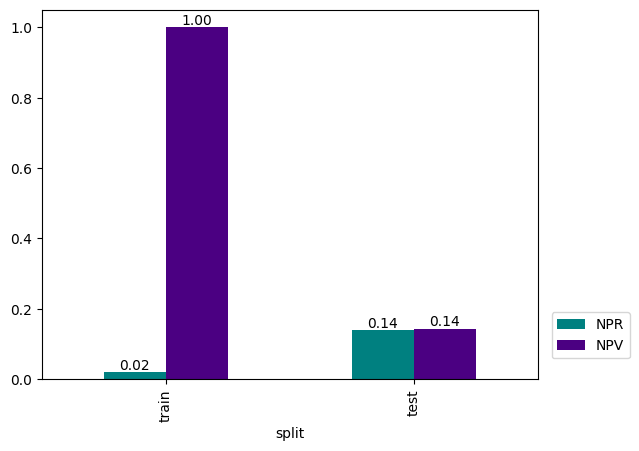

In [20]:
lhl = 30

scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['split'] != 'evaluation') & \
    (df_score['subset_name'] == 'Raw') & \
    (df_score['thld'] == 'ReLU') & \
    (df_score['num_neurons'] == lhl)

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order[:-1] + ['split', 'flavor']]
palette=['teal', 'indigo', 'steelblue']


ax = scores_best_thld_df.plot.bar(x='split', color=palette)
ax.legend(loc='best', bbox_to_anchor=(0.7, -0.3, 0.5, 0.5))
for c in ax.containers: ax.bar_label(c, fmt=lambda x: f'{x:.2f}')
# ax.set_title(f'{DATASET} - {lhl} - ReLU')

plt.show()

# Raw vs PCA Metrics - ReLU

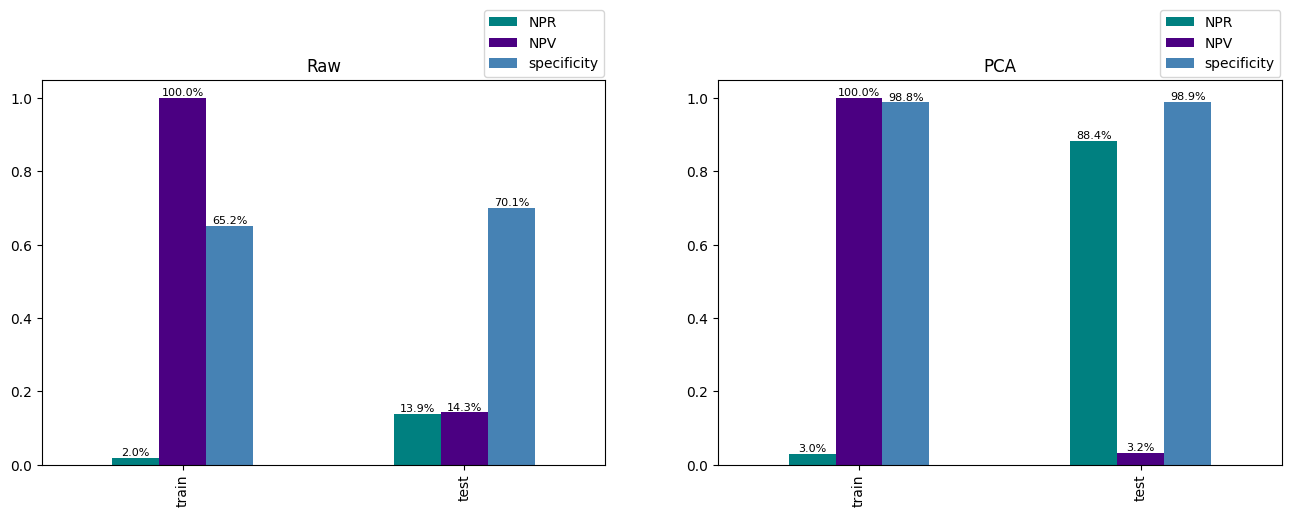

In [21]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['split'] != 'evaluation') & \
    (df_score['thld'] == thld) & \
    (df_score['num_neurons'] == lhl)

# scores_best_thld_df = df_score.loc[scores_best_thld, metric_order[:-1] + ['split', 'subset_name']].copy()
scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['split', 'subset_name']].copy()
palette=['teal', 'indigo', 'steelblue']

fig, ax = plt.subplots(1, 2, figsize=(16,5))

scores_best_thld_df.loc[scores_best_thld_df['subset_name']=='Raw'].plot.bar(x='split', color=palette, ax=ax[0])
ax[0].legend(loc='best', bbox_to_anchor=(0.51, 0.7, 0.5, 0.5))
for c in ax[0].containers: ax[0].bar_label(c, fmt=lambda x: f'{round(x,3)*100:.1f}%', fontsize=8)
ax[0].set_title('Raw')

scores_best_thld_df.loc[scores_best_thld_df['subset_name']=='PCA'].plot.bar(x='split', color=palette, ax=ax[1])
ax[1].legend(loc='best', bbox_to_anchor=(0.51, 0.7, 0.5, 0.5))
for c in ax[1].containers: ax[1].bar_label(c, fmt=lambda x: f'{round(x,3)*100:.1f}%', fontsize=8)
ax[1].set_title('PCA')

ax[0].set_xlabel('')
ax[1].set_xlabel('')

# fig.suptitle(f'{DATASET} - {lhl} - ReLU')

plt.show()

# Raw vs PCA Metrics - ReLU - All Models

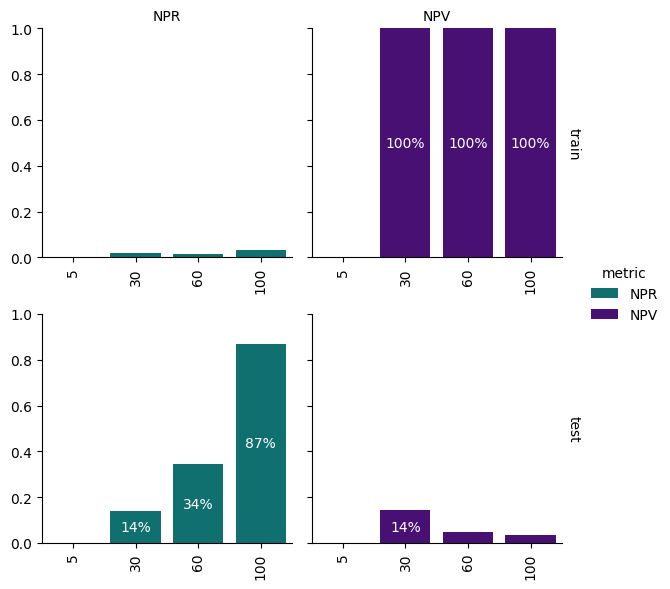

In [22]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['thld'] == thld) & \
    (df_score['split'] != 'evaluation') & \
    (df_score['subset_name'] == flavor)

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order[:-1] + ['split', 'flavor', 'num_neurons']].copy()
palette=['teal', 'indigo', 'steelblue']

scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['split', 'flavor', 'num_neurons']
)

sea = sns.FacetGrid(scores_best_thld_df, col="metric", row="split", hue_kws={'color': palette}, hue='metric',
                    margin_titles=True, sharex=False)

sea.map_dataframe(sns.barplot, "num_neurons", 'value', errorbar=None)
add_bar_labels(sea, fontsize=10)
sea.add_legend()
# sea.fig.suptitle(f'{DATASET} - {flavor.title()} - {thld.title()}', y=1.03, fontsize=14)


plt.show()

# Raw Metrics - All THLDS - All Models - No Flavors

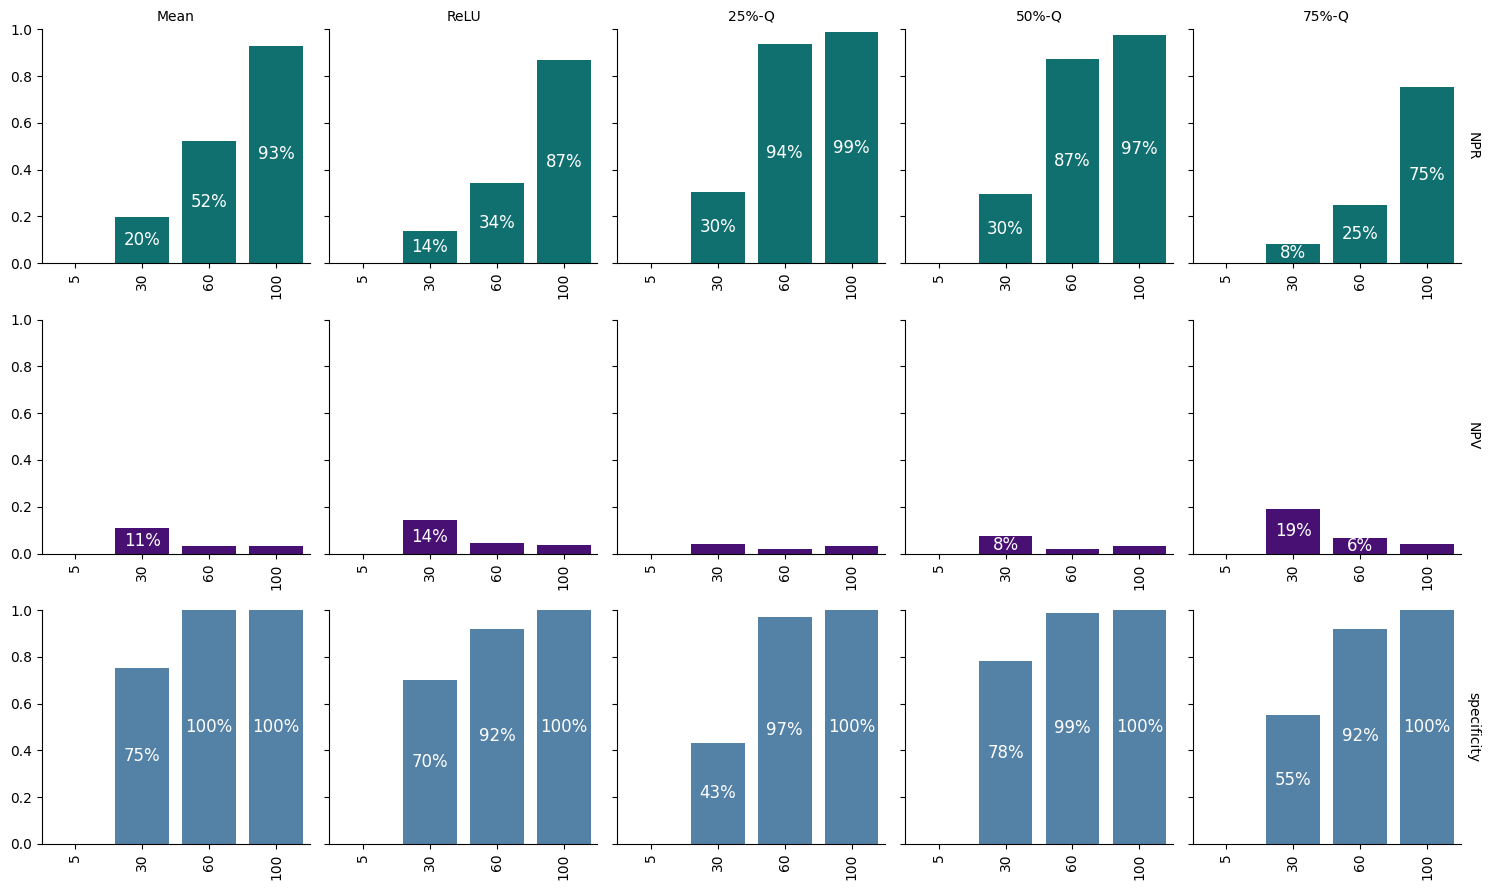

In [23]:
split = 'test'
flavor = 'Raw'

scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['split'] == split) & \
    (df_score['subset_name'] == flavor)

# scores_best_thld_df = df_score.loc[scores_best_thld, metric_order[:-1] + ['subset_name', 'thld', 'num_neurons']].copy()
scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['subset_name', 'thld', 'num_neurons']].copy()
palette=['teal', 'indigo', 'steelblue']

scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['thld', 'subset_name', 'num_neurons']
)

sea = sns.FacetGrid(scores_best_thld_df, col="thld", row="metric", hue_kws={'color': palette}, hue='metric',
                    margin_titles=True, sharex=False, col_order=thld_order)

sea.map_dataframe(sns.barplot, "num_neurons", 'value', errorbar=None)
add_bar_labels(sea, fontsize=12)
# sea.add_legend()
# sns.move_legend(sea, loc='upper left', bbox_to_anchor=(0.8, 1))
# sea.fig.suptitle(f'{DATASET} - {flavor.title()} - Thresholds', y=1.03, fontsize=14)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

In [25]:
split = 'test'
flavor = 'Raw'

scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['split'] == split) & \
    (df_score['subset_name'] == flavor)

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['thld', 'num_neurons']].copy()

temp = pd.pivot(scores_best_thld_df,
    index = 'num_neurons',columns = 'thld',
    values=metric_order
)


temp.columns = temp.columns.swaplevel(0, 1)
# temp.sort_index(axis=1, level=0, inplace=True)
temp.columns = list(map(lambda_col_names, temp.columns))


temp = temp[list(map(lambda_col_names, product(thld_order, metric_order)))]
temp.applymap(lambda_round_perc)

,Mean-NPR,Mean-NPV,Mean-specificity,ReLU-NPR,ReLU-NPV,ReLU-specificity,25%-Q-NPR,25%-Q-NPV,25%-Q-specificity,50%-Q-NPR,50%-Q-NPV,50%-Q-specificity,75%-Q-NPR,75%-Q-NPV,75%-Q-specificity
num_neurons,,,,,,,,,,,,,,,
5,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
30,19.7%,10.9%,75.4%,13.9%,14.3%,70.1%,30.5%,4.0%,43.3%,29.6%,7.5%,78.2%,8.3%,18.9%,54.9%
60,52.1%,3.3%,100.0%,34.3%,4.7%,92.0%,93.8%,1.8%,97.1%,87.2%,2.0%,98.9%,24.7%,6.5%,92.0%
100,93.1%,3.3%,100.0%,86.9%,3.5%,100.0%,98.7%,3.1%,100.0%,97.4%,3.1%,100.0%,75.5%,4.0%,100.0%


# RAW Metrics - All THLDS - All Models - All Flavors

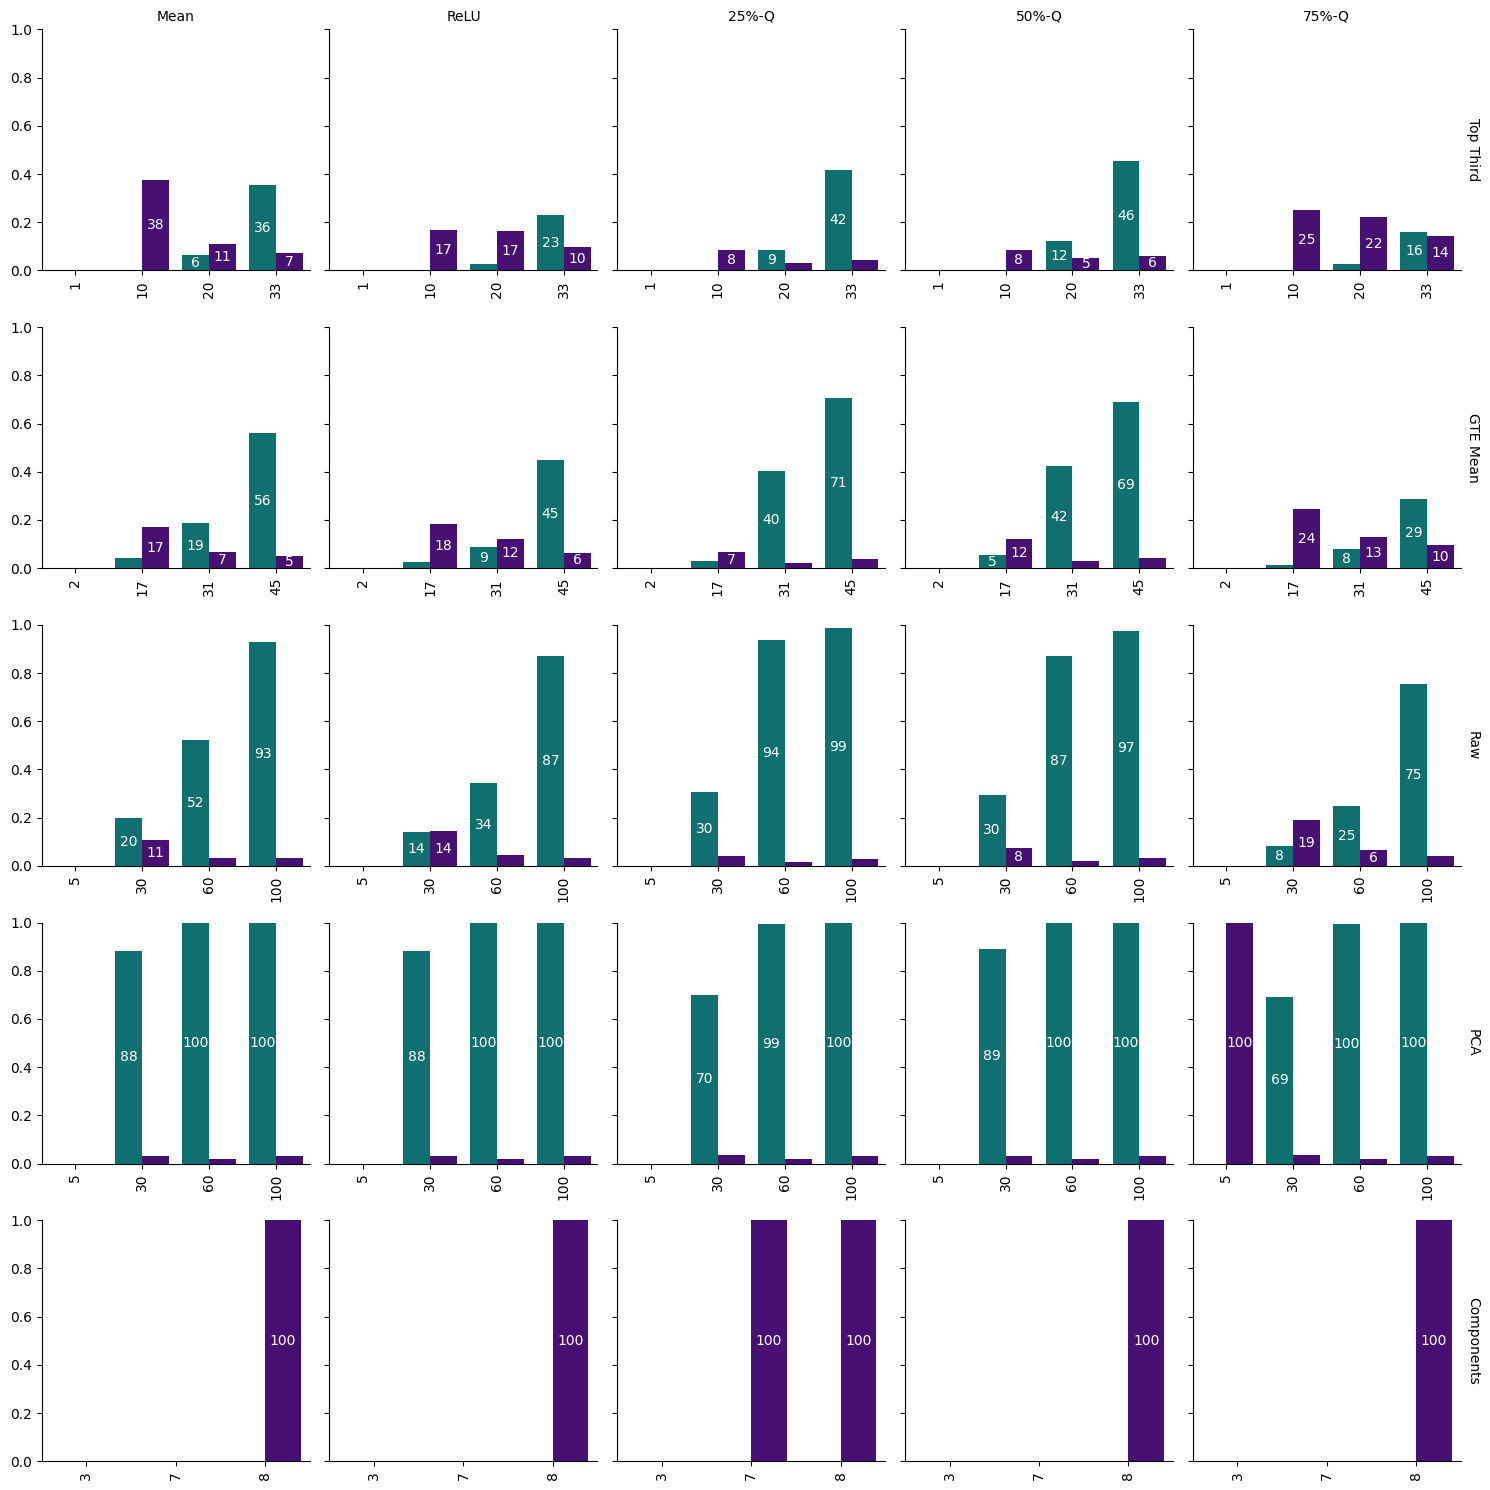

In [27]:
split = 'test'

scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['split'] == split)

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order[:-1] + ['flavor', 'thld', 'num_neurons', 'subset_name']]

# scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['thld', 'num_neurons', 'subset_name']].copy()

palette=['teal', 'indigo', 'steelblue']

scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['thld', 'num_neurons', 'subset_name', 'flavor']
)

sea = sns.FacetGrid(scores_best_thld_df, col="thld", row="subset_name", margin_titles=True, sharex=False,
                   row_order=flavor_order, col_order=thld_order)

sea.map_dataframe(sns.barplot, "num_neurons", 'value', hue="metric", errorbar=None, palette=palette)
add_bar_labels(sea, fontsize=10, fmt_perc=0)
# sea.add_legend()

# sea.fig.suptitle(f'{DATASET} - {split.title()} - Thresholds - Models - Flavors', y=1.03, fontsize=20)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

In [28]:
split = 'test'
lhls = [30,60]

scores_best_thld = (df_score['y'] == 'all') & (df_score['eta'] == 0) & \
    (df_score['split'] == split) & (df_score['lhl'].isin(lhls))

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['thld', 'lhl', 'num_neurons', 'subset_name']].copy()

temp = pd.pivot(scores_best_thld_df,
    index = ['subset_name', 'lhl', 'num_neurons'],columns = 'thld',
    values=metric_order
)


temp.columns = temp.columns.swaplevel(0, 1)
# temp.sort_index(axis=1, level=0, inplace=True)
temp.columns = list(map(lambda_col_names, temp.columns))

temp = temp.loc[flavor_order].reset_index()
temp['subset_name'] = temp[['subset_name', 'lhl', 'num_neurons']].apply(lambda_join_3_cols, axis=1)
temp.drop(['lhl', 'num_neurons'], axis=1, inplace=True)
temp.set_index('subset_name', inplace=True)

temp = temp[list(map(lambda_col_names, product(thld_order, metric_order)))]
temp.applymap(lambda_round_perc)

,Mean-NPR,Mean-NPV,Mean-specificity,ReLU-NPR,ReLU-NPV,ReLU-specificity,25%-Q-NPR,25%-Q-NPV,25%-Q-specificity,50%-Q-NPR,50%-Q-NPV,50%-Q-specificity,75%-Q-NPR,75%-Q-NPV,75%-Q-specificity
subset_name,,,,,,,,,,,,,,,
Top Third - 30 (10),0.2%,37.5%,2.1%,0.1%,16.7%,0.7%,0.1%,8.3%,0.4%,0.1%,8.3%,0.4%,0.2%,25.0%,1.4%
Top Third - 60 (20),6.3%,10.9%,39.7%,2.8%,16.5%,27.0%,8.6%,3.2%,16.1%,12.3%,5.3%,37.4%,2.7%,22.1%,34.5%
GTE Mean - 30 (17),4.3%,16.9%,25.7%,2.5%,18.2%,16.2%,2.9%,6.8%,7.0%,5.4%,12.2%,23.2%,1.4%,24.5%,12.0%
GTE Mean - 60 (31),18.7%,6.9%,74.1%,8.8%,12.2%,62.1%,40.2%,2.2%,51.7%,42.4%,3.2%,77.6%,7.9%,12.9%,58.6%
Raw - 30 (30),19.7%,10.9%,75.4%,13.9%,14.3%,70.1%,30.5%,4.0%,43.3%,29.6%,7.5%,78.2%,8.3%,18.9%,54.9%
Raw - 60 (60),52.1%,3.3%,100.0%,34.3%,4.7%,92.0%,93.8%,1.8%,97.1%,87.2%,2.0%,98.9%,24.7%,6.5%,92.0%
PCA - 30 (30),88.4%,3.2%,98.9%,88.4%,3.2%,98.9%,70.1%,3.7%,92.3%,89.1%,3.2%,99.6%,69.3%,3.8%,92.6%
PCA - 60 (60),100.0%,1.7%,100.0%,100.0%,1.7%,100.0%,99.2%,1.8%,100.0%,100.0%,1.7%,100.0%,99.5%,1.8%,100.0%
Components - 30 (7),0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


In [29]:
split = 'test'

scores_best_thld = (df_score['y'] == 'all') & (df_score['eta'] == 0) & \
    (df_score['split'] == split)

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['thld', 'lhl', 'num_neurons', 'subset_name']].copy()

temp = pd.pivot(scores_best_thld_df,
    index = ['subset_name', 'lhl', 'num_neurons'],columns = 'thld',
    values=metric_order
)


temp.columns = temp.columns.swaplevel(0, 1)
# temp.sort_index(axis=1, level=0, inplace=True)
temp.columns = list(map(lambda_col_names, temp.columns))

temp = temp.loc[flavor_order].reset_index()
temp['subset_name'] = temp[['subset_name', 'lhl', 'num_neurons']].apply(lambda_join_3_cols, axis=1)
temp.drop(['lhl', 'num_neurons'], axis=1, inplace=True)
temp.set_index('subset_name', inplace=True)

temp = temp[list(map(lambda_col_names, product(thld_order, metric_order)))]
temp.applymap(lambda_round_perc)

,Mean-NPR,Mean-NPV,Mean-specificity,ReLU-NPR,ReLU-NPV,ReLU-specificity,25%-Q-NPR,25%-Q-NPV,25%-Q-specificity,50%-Q-NPR,50%-Q-NPV,50%-Q-specificity,75%-Q-NPR,75%-Q-NPV,75%-Q-specificity
subset_name,,,,,,,,,,,,,,,
Top Third - 5 (1),0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
Top Third - 30 (10),0.2%,37.5%,2.1%,0.1%,16.7%,0.7%,0.1%,8.3%,0.4%,0.1%,8.3%,0.4%,0.2%,25.0%,1.4%
Top Third - 60 (20),6.3%,10.9%,39.7%,2.8%,16.5%,27.0%,8.6%,3.2%,16.1%,12.3%,5.3%,37.4%,2.7%,22.1%,34.5%
Top Third - 100 (33),35.5%,7.3%,85.1%,23.1%,9.9%,75.6%,41.6%,4.3%,58.7%,45.6%,5.9%,89.1%,15.8%,14.2%,73.9%
GTE Mean - 5 (2),0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
GTE Mean - 30 (17),4.3%,16.9%,25.7%,2.5%,18.2%,16.2%,2.9%,6.8%,7.0%,5.4%,12.2%,23.2%,1.4%,24.5%,12.0%
GTE Mean - 60 (31),18.7%,6.9%,74.1%,8.8%,12.2%,62.1%,40.2%,2.2%,51.7%,42.4%,3.2%,77.6%,7.9%,12.9%,58.6%
GTE Mean - 100 (45),55.9%,5.2%,96.0%,44.8%,6.4%,94.7%,70.6%,3.7%,85.8%,69.0%,4.3%,96.7%,28.8%,9.6%,90.8%
Raw - 5 (5),0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


In [30]:
split = 'evaluation'

scores_best_thld = (df_score['y'] == 'all') & (df_score['eta'] == 0) & \
    (df_score['split'] == split)

scores_best_thld_df = df_score.loc[scores_best_thld, [metric_order[0], 'thld', 'lhl', 'num_neurons', 'subset_name']].copy()

temp = pd.pivot(scores_best_thld_df,
    index = ['subset_name', 'lhl', 'num_neurons'],columns = 'thld',
    values=metric_order[0]
)


# temp.columns = temp.columns.swaplevel(0, 1)
# temp.sort_index(axis=1, level=0, inplace=True)
# temp.columns = list(map(lambda_col_names, temp.columns))

temp = temp.loc[flavor_order].reset_index()
temp['subset_name'] = temp[['subset_name', 'lhl', 'num_neurons']].apply(lambda_join_3_cols, axis=1)
temp.drop(['lhl', 'num_neurons'], axis=1, inplace=True)
temp.set_index('subset_name', inplace=True)

temp = temp[thld_order]
temp.applymap(lambda_round_perc)

thld,Mean,ReLU,25%-Q,50%-Q,75%-Q
subset_name,,,,,
Top Third - 5 (1),0.0%,0.0%,0.0%,0.0%,0.0%
Top Third - 30 (10),5.1%,3.1%,0.0%,0.3%,1.7%
Top Third - 60 (20),64.4%,52.1%,5.9%,47.6%,52.2%
Top Third - 100 (33),98.1%,93.6%,24.3%,97.0%,92.3%
GTE Mean - 5 (2),0.0%,0.0%,0.0%,0.0%,0.0%
GTE Mean - 30 (17),43.1%,25.8%,1.6%,38.0%,20.4%
GTE Mean - 60 (31),94.1%,85.4%,28.1%,85.4%,87.0%
GTE Mean - 100 (45),100.0%,99.4%,39.2%,100.0%,98.9%
Raw - 5 (5),0.0%,0.0%,0.0%,0.0%,0.0%


# Compare two monitors

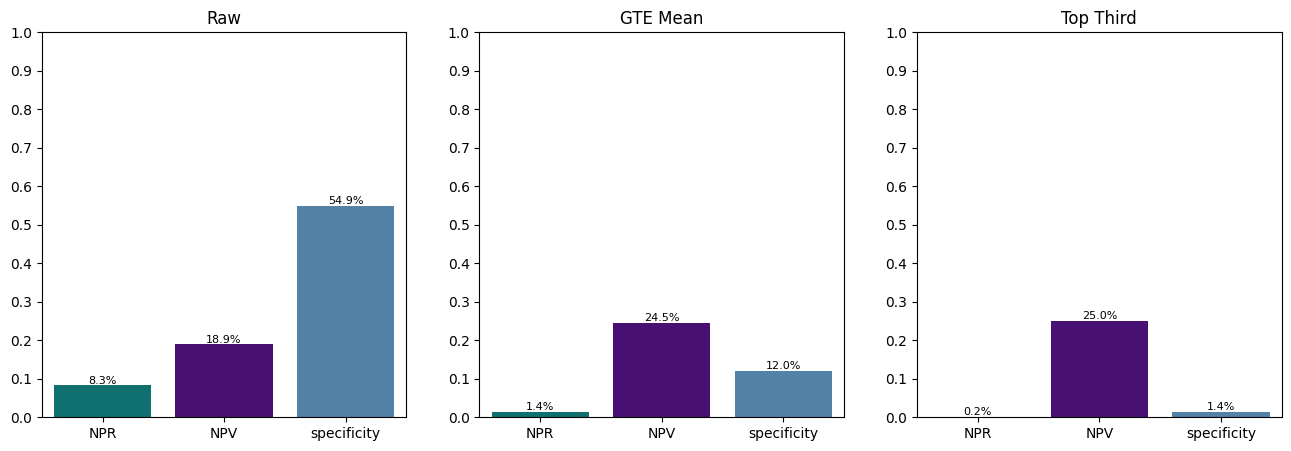

In [31]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['split'] == 'test') & \
    (df_score['lhl'] == 30) & \
    (df_score['thld'] == '75%-Q')
#     (df_score['thld'] == 'Mean')
    


scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['subset_name']].copy()
palette=['teal', 'indigo', 'steelblue']


scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['subset_name']
)



m1 = (scores_best_thld_df['subset_name'] == 'Raw')
m2 = (scores_best_thld_df['subset_name'] == 'GTE Mean')
m3 = (scores_best_thld_df['subset_name'] == 'Top Third')


fig, ax = plt.subplots(1, 3, figsize=(16,5))

sns.barplot(x='metric', y='value', data=scores_best_thld_df.loc[m1], palette=palette, ax=ax[0])
# ax[0].get_legend().remove()
for c in ax[0].containers: ax[0].bar_label(c, fmt=lambda x: f'{round(x,3)*100:.1f}%', fontsize=8)
ax[0].set_title('Raw')

sns.barplot(x='metric', y='value', data=scores_best_thld_df.loc[m2], palette=palette, ax=ax[1])
# ax[1].get_legend().remove()
for c in ax[1].containers: ax[1].bar_label(c, fmt=lambda x: f'{round(x,3)*100:.1f}%', fontsize=8)
ax[1].set_title('GTE Mean')

sns.barplot(x='metric', y='value', data=scores_best_thld_df.loc[m3], palette=palette, ax=ax[2])
# ax[2].get_legend().remove()
for c in ax[2].containers: ax[2].bar_label(c, fmt=lambda x: f'{round(x,3)*100:.1f}%', fontsize=8)
ax[2].set_title('Top Third')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[1].set_yticks(np.arange(0, 1.1, 0.1))
ax[2].set_yticks(np.arange(0, 1.1, 0.1))

# fig.suptitle(f'{DATASET} - {lhl} - ReLU')

plt.show()

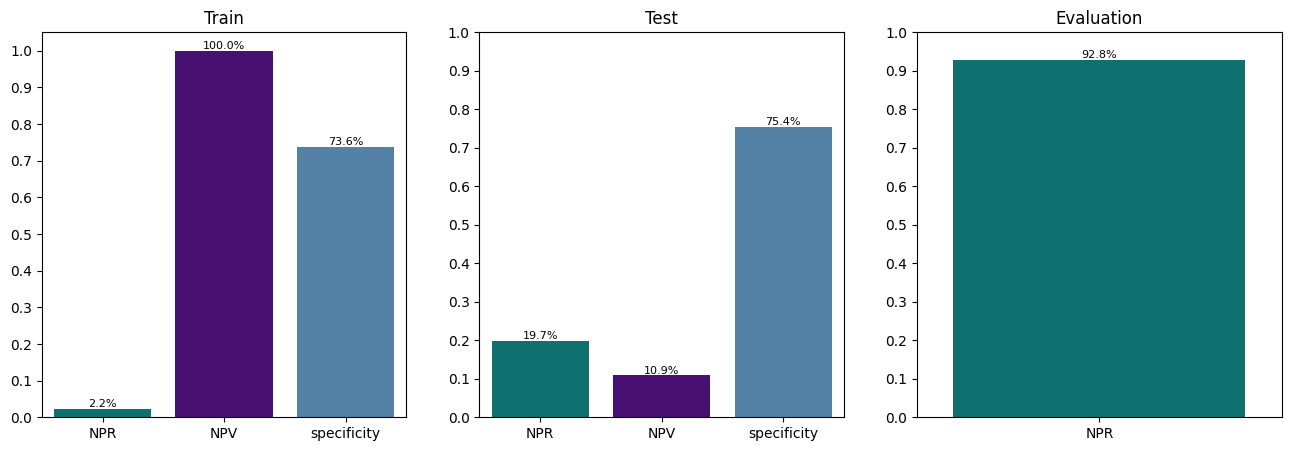

In [33]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['lhl'] == 30) & \
    (df_score['subset_name'] == 'Raw')
    

scores_best_thld = scores_best_thld & (df_score['thld'] == 'Mean')
# scores_best_thld = scores_best_thld & (df_score['thld'] == '75%-Q')

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['split']].copy()
palette=['teal', 'indigo', 'steelblue']


scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['split']
)

scores_best_thld_df = scores_best_thld_df.loc[~((scores_best_thld_df['split'] == 'evaluation') & \
                                                (scores_best_thld_df['metric'] != 'NPR'))]

m1 = (scores_best_thld_df['split'] == 'train')
m2 = (scores_best_thld_df['split'] == 'test')
m3 = (scores_best_thld_df['split'] == 'evaluation')


fig, ax = plt.subplots(1, 3, figsize=(16,5))

sns.barplot(x='metric', y='value', data=scores_best_thld_df.loc[m1], palette=palette, ax=ax[0])
# ax[0].get_legend().remove()
for c in ax[0].containers: ax[0].bar_label(c, fmt=lambda x: f'{round(x,3)*100:.1f}%', fontsize=8)
ax[0].set_title('Train')

sns.barplot(x='metric', y='value', data=scores_best_thld_df.loc[m2], palette=palette, ax=ax[1])
# ax[1].get_legend().remove()
for c in ax[1].containers: ax[1].bar_label(c, fmt=lambda x: f'{round(x,3)*100:.1f}%', fontsize=8)
ax[1].set_title('Test')

sns.barplot(x='metric', y='value', data=scores_best_thld_df.loc[m3], palette=palette, ax=ax[2])
# ax[2].get_legend().remove()
for c in ax[2].containers: ax[2].bar_label(c, fmt=lambda x: f'{round(x,3)*100:.1f}%', fontsize=8)
ax[2].set_title('Evaluation')

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[1].set_yticks(np.arange(0, 1.1, 0.1))
ax[2].set_yticks(np.arange(0, 1.1, 0.1))

# fig.suptitle(f'{DATASET} - {lhl} - ReLU')

plt.show()

In [34]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['lhl'] == 30) & \
    (df_score['flavor'] == 'raw')



# scores_best_thld = scores_best_thld & (df_score['thld'] == 'Mean')
scores_best_thld = scores_best_thld & (df_score['thld'] == '75%-Q')
    

cols = np.setdiff1d(df_score.columns.to_numpy(), ['y','eta', 'num_neurons', 'thld', 'flavor', 'lhl', 'batch_size'])

scores_best_thld_df = df_score.loc[scores_best_thld, cols].copy()


scores_best_thld_df

,NPR,NPV,specificity,split,subset_name,total_count,total_misclassified,unrecognized,unrecognized_and_classified,unrecognized_and_misclassified
10,0.017450,1.000000,0.580699,train,Raw,60000,1803,1047,0,1047
54,0.082632,0.189091,0.549296,test,Raw,9984,284,825,669,156
89,0.666000,1.000000,0.000000,evaluation,Raw,1000,1000,666,666,0
106,0.003783,1.000000,0.125901,train,GTE Mean,60000,1803,227,0,227
150,0.013922,0.244604,0.119718,test,GTE Mean,9984,284,139,105,34
185,0.204000,1.000000,0.000000,evaluation,GTE Mean,1000,1000,204,204,0
202,0.000467,1.000000,0.015530,train,Top Third,60000,1803,28,0,28
246,0.001603,0.250000,0.014085,test,Top Third,9984,284,16,12,4
281,0.017000,1.000000,0.000000,evaluation,Top Third,1000,1000,17,17,0


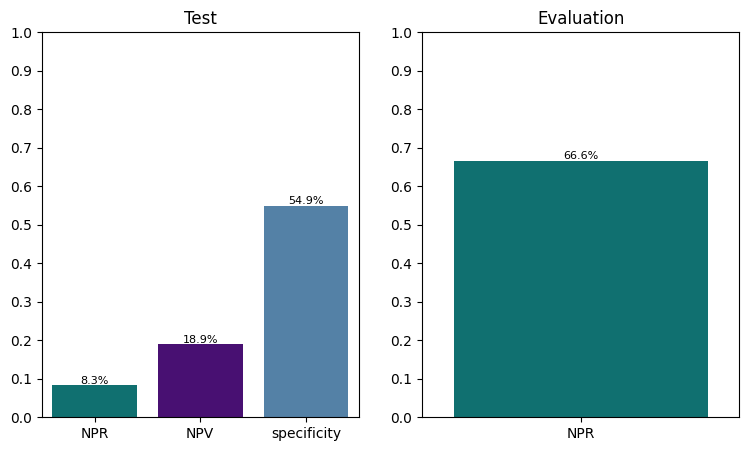

In [42]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['lhl'] == 30) & \
    (df_score['subset_name'] == 'Raw')
    

# scores_best_thld = scores_best_thld & (df_score['thld'] == 'Mean')
scores_best_thld = scores_best_thld & (df_score['thld'] == '75%-Q')

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['split']].copy()
palette=['teal', 'indigo', 'steelblue']


scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['split']
)

scores_best_thld_df = scores_best_thld_df.loc[~((scores_best_thld_df['split'] == 'evaluation') & \
                                                (scores_best_thld_df['metric'] != 'NPR'))]

m2 = (scores_best_thld_df['split'] == 'test')
m3 = (scores_best_thld_df['split'] == 'evaluation')


fig, ax = plt.subplots(1, 2, figsize=(9,5))

sns.barplot(x='metric', y='value', data=scores_best_thld_df.loc[m2], palette=palette, ax=ax[0])
# ax[0].get_legend().remove()
for c in ax[0].containers: ax[0].bar_label(c, fmt=lambda x: f'{round(x,3)*100:.1f}%', fontsize=8)
ax[0].set_title('Test')

sns.barplot(x='metric', y='value', data=scores_best_thld_df.loc[m3], palette=palette, ax=ax[1])
# ax[1].get_legend().remove()
for c in ax[1].containers: ax[1].bar_label(c, fmt=lambda x: f'{round(x,3)*100:.1f}%', fontsize=8)
ax[1].set_title('Evaluation')

ax[0].set_xlabel('')
ax[1].set_xlabel('')

ax[0].set_ylabel('')
ax[1].set_ylabel('')

ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[1].set_yticks(np.arange(0, 1.1, 0.1))

# fig.suptitle(f'{DATASET} - {lhl} - ReLU')

plt.show()

# RAW Metrics - All THLDS - All Falvors - All Eta - ONE Model

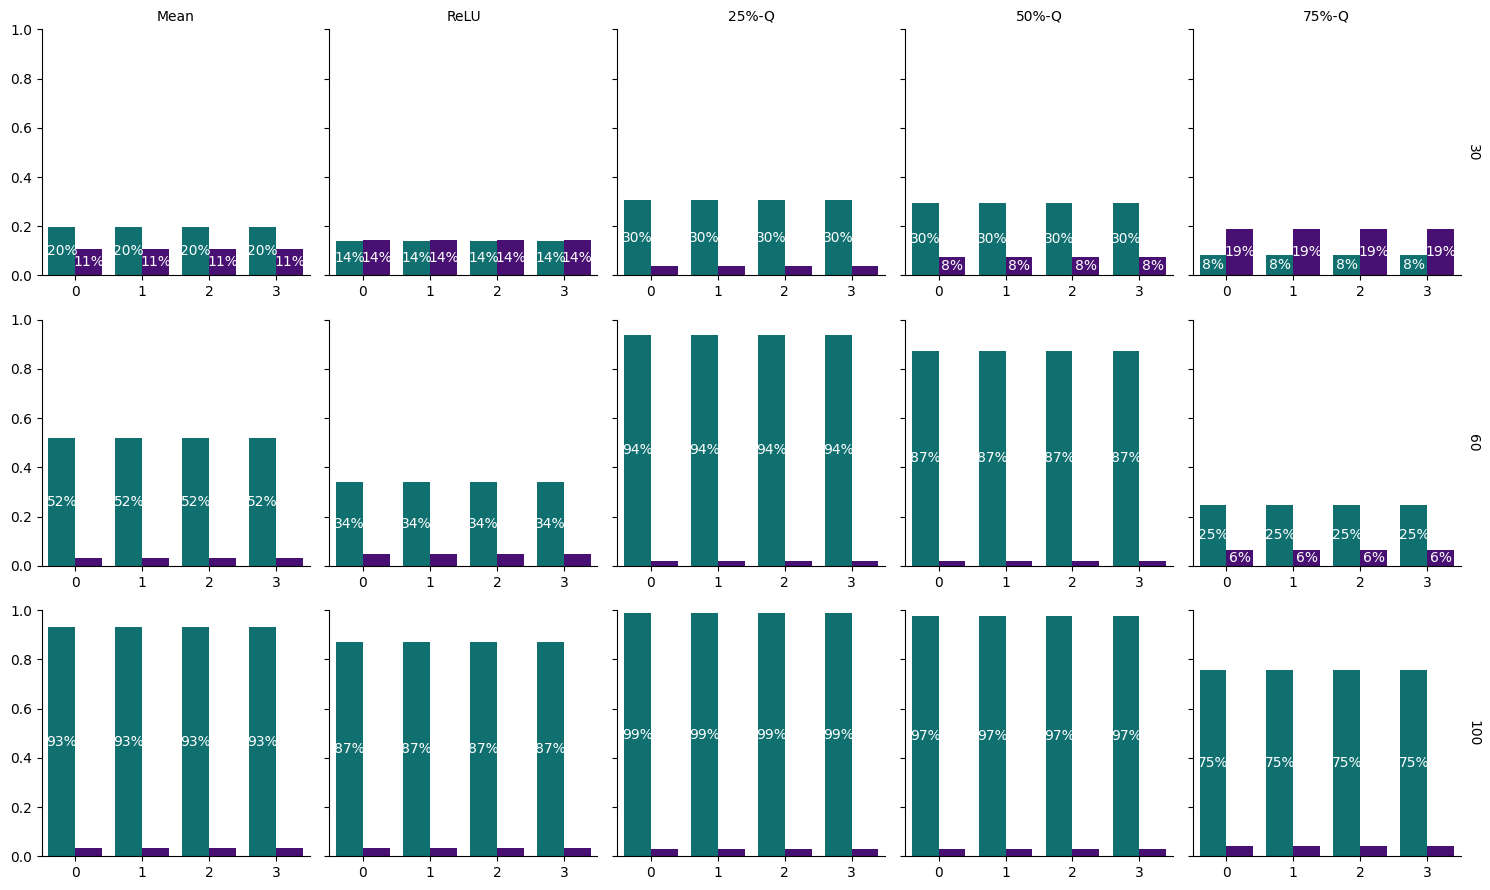

In [35]:
split = 'test'
lhl = 30

scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['split'] == split) & \
    (df_score['num_neurons'] != 5) & \
    (df_score['subset_name'] == 'Raw')

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order[:-1] + ['thld', 'num_neurons', 'eta']]
# scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['thld', 'num_neurons', 'subset_name', 'eta']]

palette=['teal', 'indigo', 'steelblue']

scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['thld', 'num_neurons', 'eta']
)

sea = sns.FacetGrid(scores_best_thld_df, col="thld", row="num_neurons", margin_titles=True, sharex=False,
                   col_order=thld_order)

sea.map_dataframe(sns.barplot, "eta", "value", hue="metric", errorbar=None, palette=palette)
add_bar_labels(sea, 0)
# sea.fig.suptitle(f"{DATASET} - {lhl} - {split.title()} - Thresholds - Flavors - Hamming Distance",y=1.03, fontsize=20)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

In [36]:
split = 'test'
lhls = [30,60]
etas = [0,3]

scores_best_thld = (df_score['y'] == 'all') & (df_score['eta'].isin(etas)) & \
    (df_score['split'] == split) & (df_score['lhl'].isin(lhls)) & \
    (~(df_score['subset_name'].isin(['PCA', 'Components'])))

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['eta','thld', 'lhl', 'num_neurons', 'subset_name']].copy()

temp = pd.pivot(scores_best_thld_df,
    index = ['subset_name', 'lhl', 'num_neurons', 'eta'],columns = 'thld',
    values=metric_order
)


temp.columns = temp.columns.swaplevel(0, 1)
temp.sort_index(axis=1, level=0, inplace=True)
temp.columns = list(map(lambda_col_names, temp.columns))

temp = temp.loc[flavor_order[:-2]].reset_index()
temp['subset_name'] = temp[['subset_name', 'lhl', 'num_neurons']].apply(lambda_join_3_cols, axis=1)
temp.drop(['lhl', 'num_neurons'], axis=1, inplace=True)
temp.set_index('subset_name', inplace=True)

cols_order = list(map(lambda_col_names, product(thld_order, metric_order)))

temp = temp[['eta'] + cols_order]
temp[cols_order] = temp[cols_order].applymap(lambda_round_perc)

temp

,eta,Mean-NPR,Mean-NPV,Mean-specificity,ReLU-NPR,ReLU-NPV,ReLU-specificity,25%-Q-NPR,25%-Q-NPV,25%-Q-specificity,50%-Q-NPR,50%-Q-NPV,50%-Q-specificity,75%-Q-NPR,75%-Q-NPV,75%-Q-specificity
subset_name,,,,,,,,,,,,,,,,
Top Third - 30 (10),0,0.2%,37.5%,2.1%,0.1%,16.7%,0.7%,0.1%,8.3%,0.4%,0.1%,8.3%,0.4%,0.2%,25.0%,1.4%
Top Third - 30 (10),3,0.2%,37.5%,2.1%,0.1%,16.7%,0.7%,0.1%,8.3%,0.4%,0.1%,8.3%,0.4%,0.2%,25.0%,1.4%
Top Third - 60 (20),0,6.3%,10.9%,39.7%,2.8%,16.5%,27.0%,8.6%,3.2%,16.1%,12.3%,5.3%,37.4%,2.7%,22.1%,34.5%
Top Third - 60 (20),3,6.3%,10.9%,39.7%,2.8%,16.5%,27.0%,8.6%,3.2%,16.1%,12.3%,5.3%,37.4%,2.7%,22.1%,34.5%
GTE Mean - 30 (17),0,4.3%,16.9%,25.7%,2.5%,18.2%,16.2%,2.9%,6.8%,7.0%,5.4%,12.2%,23.2%,1.4%,24.5%,12.0%
GTE Mean - 30 (17),3,4.3%,16.9%,25.7%,2.5%,18.2%,16.2%,2.9%,6.8%,7.0%,5.4%,12.2%,23.2%,1.4%,24.5%,12.0%
GTE Mean - 60 (31),0,18.7%,6.9%,74.1%,8.8%,12.2%,62.1%,40.2%,2.2%,51.7%,42.4%,3.2%,77.6%,7.9%,12.9%,58.6%
GTE Mean - 60 (31),3,18.7%,6.9%,74.1%,8.8%,12.2%,62.1%,40.2%,2.2%,51.7%,42.4%,3.2%,77.6%,7.9%,12.9%,58.6%
Raw - 30 (30),0,19.7%,10.9%,75.4%,13.9%,14.3%,70.1%,30.5%,4.0%,43.3%,29.6%,7.5%,78.2%,8.3%,18.9%,54.9%


In [37]:
df_info['num_neurons'].drop_duplicates()

info_best_thld = (df_info['lhl'] == 30) & \
    (df_info['subset_name'] == 'raw') & \
    (df_info['thld'] == 'qth_0.5')


info_best_thld_df = df_info.loc[info_best_thld]

info_best_thld_df['build_time_min'] = info_best_thld_df['build_time_min'].cumsum().round(1)
info_best_thld_df['num_patterns_cum'] = (info_best_thld_df['num_patterns']*info_best_thld_df['num_unique_patterns_%']/100).cumsum().apply(lambda x: f"{x:,.0f}")
info_best_thld_df['num_patterns'] = info_best_thld_df['num_patterns'].apply(lambda x: f"{x:,.0f}")
info_best_thld_df['num_unique_patterns_%'] = info_best_thld_df['num_unique_patterns_%'].apply(lambda x: f"{x}%")
info_best_thld_df['eta'] = info_best_thld_df['eta'].astype(np.uint8)

info_cols = ['eta','build_time_min','num_patterns', 'num_patterns_cum', 'num_unique_patterns_%']

info_best_thld_df[info_cols].set_index('eta')

,build_time_min,num_patterns,num_patterns_cum,num_unique_patterns_%
eta,,,,
0,1.0,"58,197","23,570",40.5%
1,19.1,"707,370","651,714",88.8%
2,24.2,"325,603","965,270",96.3%
3,25.9,"157,637","1,120,700",98.6%


In [38]:
# scores_best_thld_df.loc[scores_best_thld_df['subset_name'] == 'components']

# RAW Metrics - MEAN - ONE Model

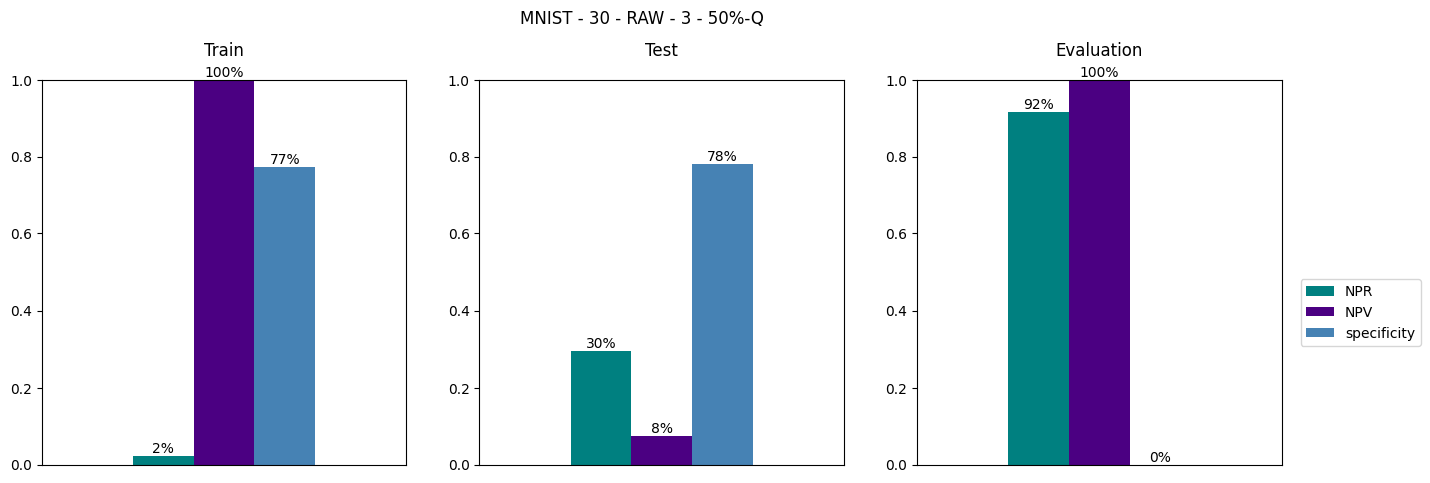

In [39]:
lhl = lhl
eta = 3
flavor = 'Raw'
thld = '50%-Q'


scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['lhl'] == lhl) & \
    (df_score['eta'] == eta) & \
    (df_score['subset_name'] == flavor) & \
    (df_score['thld'] == thld)

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['split']]
palette=['teal', 'indigo', 'steelblue']

fig, ax = plt.subplots(1, 3, figsize=(16,5))

for s, a in zip(scores_best_thld_df['split'].values, ax):
    scores_best_thld_df.loc[scores_best_thld_df['split']==s, metric_order].plot.bar(color=palette, ax=a)
    a.get_legend().remove()
    a.set_xticks([])
    a.set_title(s.title(), y=1.04)
    


ax[2].legend(loc='best', bbox_to_anchor=(0.9, 0, 0.5, 0.5))

for a in ax:
    a.set_ylim(0, 1)
    a.set_xlabel('')
    for c in a.containers: a.bar_label(c, fmt=lambda x: f'{x*100:.0f}%')

fig.suptitle(f'{DATASET} - {lhl} - {flavor.upper()} - {eta} - {thld}', y=1.02)

plt.show()

In [40]:
df_score.loc[scores_best_thld]

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_and_classified,NPR,NPV,specificity,eta,subset_name,num_neurons,split,thld,flavor,lhl,batch_size
331,all,60000,1803,1395,1395,0,0.023250,1.000000,0.77371,3,Raw,30,train,50%-Q,raw,30,32
375,all,9984,284,2952,222,2730,0.295673,0.075203,0.78169,3,Raw,30,test,50%-Q,raw,30,32
383,all,1000,1000,916,0,916,0.916000,1.000000,0.00000,3,Raw,30,evaluation,50%-Q,raw,30,32
